# Linear regression - sklearn

In this section, we will cover:

- fitting different linear regression models with sklearn
- normalization and encoding of features
- score analysis: MSE and variance explained: $R^2$
- residual analysis
- most important features
- comparing the models: conclusions


## Feature selection

This time we will not be manually selecting features. Some sklearn linear regressor models uses regularization, and that should address the lack of feature selection.

This has an important consequence, however: we will be using all features, even the ones which are not linearly correlated with the outcome. This means we will be trying to fit a linear model on a case that may be not strictly linear.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/df_resample.csv')
df.head()

symboling        make fuel_type aspiration num_of_doors body_style  \
0          0      nissan       gas        std         four      sedan   
1          3  volkswagen       gas        std          two  hatchback   
2          1         bmw       gas        std         four      sedan   
3          2      subaru       gas        std          two  hatchback   
4          0       mazda    diesel        std         four      sedan   

  drive_wheels engine_location  wheel_base  length  ...  engine_size  \
0          fwd           front        97.2   173.4  ...          120   
1          fwd           front        94.5   165.7  ...          109   
2          rwd           front       103.5   189.0  ...          164   
3          fwd           front        93.7   156.9  ...           97   
4          rwd           front       104.9   175.0  ...          134   

   fuel_system  bore stroke compression_ratio  horsepower peak_rpm  city_mpg  \
0         2bbl  3.33   3.47               8.5        97.0   5200.0        27   
1         mpfi  3.19   3.40               8.5        90.0   5500.0        24   
2         mpfi  3.31   3.19               9.0       121.0   4250.0        20   
3         2bbl  3.62   2.36               9.0        69.0   4900.0        31   
4          idi  3.43   3.64              22.0        72.0   4200.0        31   

   highway_mpg    price  
0           34   9549.0  
1           29   9980.0  
2           25  24565.0  
3           36   5118.0  
4           39  18344.0  

[5 rows x 25 columns]

In [2]:
X = df.copy()
X.drop('price', axis=1, inplace=True)
y = np.log(df.price) # as discussed, we are going to use the log transform here

## Train-test split#
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=95276
)


## Normalization and encoding of features

The range of the numeric features varies a lot for each one of them:

- bore range: ~2
- curb range: ~3500

Also, its easy to see that they are measuring completely different things and therefore are in different scales.

In order to properly fit linear regression models with regularization, we must account for those differences.

Also, it is import to encode the categories, like fuel-type, so sklearn can use them.

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

with open('data/category_list', 'rb') as file:
    cat_cols = pickle.load(file)

# numeric columns
num_cols = [col for col in X_train.columns if col not in cat_cols]

# normalize numeric features
scaler = StandardScaler()
num_scaled = scaler.fit_transform(X_train[num_cols])

# encode categories
encoder = OneHotEncoder(sparse=False)
cat_encoded = encoder.fit_transform(X_train[cat_cols])

# all together
X_train_proc = np.concatenate([cat_encoded, num_scaled] ,axis=1)
X_train_proc.shape

(7000, 73)

In [4]:
# apply transformations on test set
num_scaled = scaler.transform(X_test[num_cols])

# encode categories
cat_encoded = encoder.transform(X_test[cat_cols])

# all together
X_test_proc = np.concatenate([cat_encoded, num_scaled] ,axis=1)
X_test_proc.shape

(3000, 73)

## Hyper-parameter tuning and Cross Validation

It is important to note that we are going to use the gridsearchCV method, so we can iterate over a series of hyper-parameters for each model in order to find the best combination of them through cross validation.

## Linear regression model

Lets start trying a simple sklearn linear regression model, without regularization.




In [5]:
%load_ext autoreload
%autoreload 2

import aux_functions as aux

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
grid_params = {'fit_intercept': [True, False]}
name = 'Linear Regression'
data = (X_train_proc, y_train, X_test_proc, y_test)

linear_results = aux.make_regressor(name, model, grid_params, data)

Linear Regression
Score r2: 0.9707 
Score MSE: 2.122e+06 
Time: 1.5e+01s
{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'normalize': False}


## Regularized models - Ridge regularization

Ridge regression uses a penalty L2 factor for the least important regressors. 

- L2: least squared deviation $resid = \sum{(y_i - \hat y_i)^2} + \lambda \sum{\beta^2}$

However, the least squares regularization is not robust: it is sensitive to outliers.

In [7]:
from sklearn.linear_model import Ridge

model = Ridge()
grid_params = {'alpha': [.001, .01, .1, 1]}
name = 'Ridge Regression'
ridge_results = aux.make_regressor(name, model, grid_params, data)

Ridge Regression
Score r2: 0.9707 
Score MSE: 2.123e+06 
Time: 4.1s
{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


## Regularized models - Lasso

Lasso regression uses a stronger penalty for the least important regressors, the L1.

That said, lasso will perform feature selection and it is not a stable solution.

- L1: least absolute deviation: $resid = \sum{(y_i - \hat y_i)^2} + \lambda \sum{|\beta|}$



In [8]:
from sklearn.linear_model import Lasso

model = Lasso()
grid_params = {'alpha': [.001, .01, .1, 1]}
name = 'Lasso Regression'
lasso_results = aux.make_regressor(name, model, grid_params, data)

Lasso Regression
Score r2: 0.9599 
Score MSE: 2.637e+06 
Time: 0.49s
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Huber Regressor

Huber uses L2 and L1 penalty. This makes it specially strong against outliers:

In [9]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor(max_iter=1000)
grid_params = {
    'alpha': [.001, .01, .1],
    'epsilon': [1, 5, 10]
}
name = 'HUbber Regression'
hubber_results = aux.make_regressor(name, model, grid_params, data)


HUbber Regression
Score r2: 0.9707 
Score MSE: 2.123e+06 
Time: 6.4e+01s
{'alpha': 0.001, 'epsilon': 10, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-05, 'warm_start': False}


## Comparing models - MSE and $R^2$

In [10]:
df_scores = pd.DataFrame({
    'MSE': [
        linear_results[2]['mse'],
        ridge_results[2]['mse'],
        lasso_results[2]['mse'],
        hubber_results[2]['mse'],

        ],
    'r2': [
        linear_results[2]['r2'],
        ridge_results[2]['r2'],
        lasso_results[2]['r2'],
        hubber_results[2]['r2'],
        ],
    'model name': [
        linear_results[2]['model name'],
        ridge_results[2]['model name'],
        lasso_results[2]['model name'],
        hubber_results[2]['model name'],
        ],
    'time': [
        linear_results[2]['time'],
        ridge_results[2]['time'],
        lasso_results[2]['time'],
        hubber_results[2]['time'],
        ],
    },
#     index=['linear', 'ridge', 'lasso', 'hubber']
)

# load ols results
df_scores_ols = pd.read_csv('data/scores.csv')
df_scores = pd.concat([df_scores, df_scores_ols], axis=0)
df_scores.to_csv('data/sk_scores.csv', index=False)
df_scores.sort_values(by='MSE').round(4)

MSE      r2         model name     time
0  2.122211e+06  0.9707  Linear Regression  14.9926
3  2.123061e+06  0.9707  HUbber Regression  63.8937
1  2.123265e+06  0.9707   Ridge Regression   4.0631
0  2.175057e+06  0.9690                ols   0.7920
2  2.636549e+06  0.9599   Lasso Regression   0.4869

## Most important features

Lets check what are the most important features, aside from make:

In [11]:
model = ridge_results[0]

cat_list = []
# make is the categories_[0]
for item in encoder.categories_[1:]:
    for cat in item:
        cat_list.append(cat)

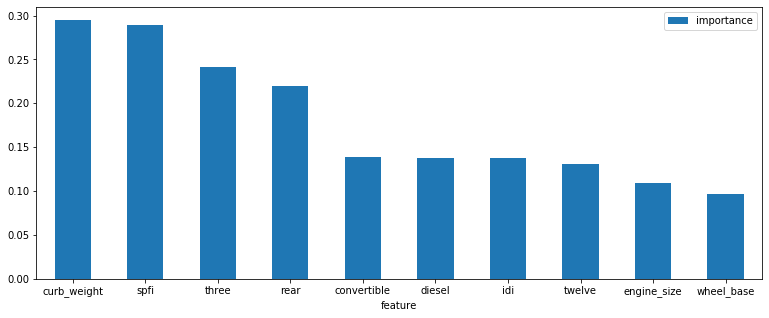

In [12]:
features = cat_list + num_cols
coefs = model.coef_

# coefs 0 to 21 are the make coefs
df_features = pd.DataFrame({'feature': features, 'importance': coefs[21:]})
(df_features.sort_values(by='importance', ascending=False)
    .set_index('feature').head(10)
    .plot(kind='bar', figsize=(13, 5), rot=0)
)

## Comparing the models - conclusions

- MSE analysis shows better results for the Linear model: smallest MSE
- $R^2$ analysis shows a tie between Ridge and Linear models
- Ridge model would be the safest choice: 
- OLS has a worse performance because it was built on the assumption of a linear phenomena, using only linearly correlated variables.

In [14]:
df_scores.sort_values(by='MSE').round(4)

MSE      r2         model name     time
0  2.122211e+06  0.9707  Linear Regression  14.9926
3  2.123061e+06  0.9707  HUbber Regression  63.8937
1  2.123265e+06  0.9707   Ridge Regression   4.0631
0  2.175057e+06  0.9690                ols   0.7920
2  2.636549e+06  0.9599   Lasso Regression   0.4869